# 0062_Kaggle - Houseprice - ensemble models submission

Base on my previous notebook `#0061_practice_houseprice`, this notebook is for the submission of 'Houseprice' prediction with **advanced feature engineering and ensenble models (NN, xgboost, catboost)**. The best score of submission is *0.12735*.

In [1]:
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = Path("/Users/applewang/Desktop/Study_Materials_2023_2025/fastai_course/my-practice/house-prices-advanced-regression-techniques")
Path.BASE_PATH = path
path.ls()

(#4) [Path('test.csv'),Path('data_description.txt'),Path('train.csv'),Path('sample_submission.csv')]

In [3]:
train_df = pd.read_csv(path/'train.csv', low_memory=False)
train_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,...,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,...,2008,WD,Normal,208500
1,2,20,RL,80.0,...,2007,WD,Normal,181500
2,3,60,RL,68.0,...,2008,WD,Normal,223500


## process data

In [4]:
def add_features(df, is_train=True):
    """增强版特征工程，区分训练集和测试集"""
    df = df.copy()
    
    # 面积相关特征
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBathrooms'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
    df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    df['HasPool'] = (df['PoolArea'] > 0).astype(int)
    df['Has2ndFlr'] = (df['2ndFlrSF'] > 0).astype(int)
    df['HasGarage'] = (df['GarageArea'] > 0).astype(int)
    df['HasBsmt'] = (df['TotalBsmtSF'] > 0).astype(int)
    df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
    
    # 新增面积特征
    df['TotalArea'] = df['TotalSF'] + df['GarageArea'] + df['TotalPorchSF']
    df['LivingArea'] = df['GrLivArea'] + df['TotalBsmtSF']
    
    # 质量相关特征
    qual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
    df['ExterQual_num'] = df['ExterQual'].map(qual_map)
    df['ExterCond_num'] = df['ExterCond'].map(qual_map)
    df['BsmtQual_num'] = df['BsmtQual'].map(qual_map)
    df['BsmtCond_num'] = df['BsmtCond'].map(qual_map)
    df['HeatingQC_num'] = df['HeatingQC'].map(qual_map)
    df['KitchenQual_num'] = df['KitchenQual'].map(qual_map)
    df['FireplaceQu_num'] = df['FireplaceQu'].map(qual_map)
    df['GarageQual_num'] = df['GarageQual'].map(qual_map)
    df['GarageCond_num'] = df['GarageCond'].map(qual_map)
    
    # 综合质量分数
    df['OverallGrade'] = df['OverallQual'] * df['OverallCond']
    df['ExterGrade'] = df['ExterQual_num'] * df['ExterCond_num']
    df['GarageGrade'] = df['GarageQual_num'] * df['GarageCond_num']
    df['TotalQual'] = df['OverallQual'] + df['ExterQual_num'] + df['BsmtQual_num'] + df['KitchenQual_num']
    
    # 年份相关特征
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df['IsNew'] = (df['Age'] <= 2).astype(int)
    df['YearsSinceRemodel'] = df['YrSold'] - df['YearRemodAdd']
    df['RecentRemodel'] = (df['YearsSinceRemodel'] <= 2).astype(int)
    df['AgeRemod'] = df['YrSold'] - df['YearRemodAdd']
    df['IsNewRemod'] = (df['AgeRemod'] <= 2).astype(int)
    
    # 处理 GarageYrBlt
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])
    df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']
    
    # 分类特征编码
    df['MSSubClass'] = df['MSSubClass'].astype(str)
    df['YrSold'] = df['YrSold'].astype(str)
    df['MoSold'] = df['MoSold'].astype(str)
    
    # 处理缺失值
    df['LotFrontage'] = df.groupby(['Neighborhood', 'LotArea'])['LotFrontage'].transform(
        lambda x: x.fillna(x.median()) if not x.isnull().all() else x.fillna(0)
    )
    # 处理可能遗漏的缺失值
    features = list(df.columns)
    for i in features:
        if df[i].isnull().sum() >0:
            if df[i].dtype == 'object': df[i] = df[i].fillna('None') #features may have such conditions instead of missing records
            else: df[i] = df[i].fillna(df[i].median())
    
    # 创建比率特征
    df['LivLotRatio'] = df['GrLivArea'] / df['LotArea']
    df['Density'] = df['GrLivArea'] / (df['LotArea'] + 1)
    df['PricePerTotalSF'] = df['TotalSF'] / (df['LotArea'] + 1)
    df['PricePerLivArea'] = df['LivingArea'] / (df['LotArea'] + 1)
    
    # 邻居特征
    df['NeighborhoodBin'] = pd.qcut(df.groupby('Neighborhood')['LotArea'].transform('median'), 5, labels=False)
    
    if is_train:
        # 对数变换目标变量
        df['SalePrice'] = np.log1p(df['SalePrice'])
        
        # 价格相关特征（仅用于训练集）
        df['Price_per_SF'] = df['SalePrice'] / df['TotalSF']
        df['Price_per_Room'] = df['SalePrice'] / df['TotRmsAbvGrd']
        df['Price_per_Bath'] = df['SalePrice'] / df['TotalBathrooms']
    
    return df


In [5]:
df = add_features(train_df, is_train=True)

In [6]:
df.isnull().sum().sum()

0

### detect anomoly

In [7]:
def handle_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df[col] = df[col].clip(Q1 - 1.5*IQR, Q3 + 1.5*IQR)
    return df

In [8]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df = handle_outliers(df, numeric_cols)

In [9]:
df.shape

(1460, 119)

## Dataloaders

In [10]:
splits = RandomSplitter(valid_pct=0.2, seed=20)(range_of(df))
cont_names = [
        'Age', 'TotalSF', 'TotalBathrooms', 'TotalPorchSF',
        'OverallGrade', 'YearsSinceRemodel', 'ExterQual_num',
        'KitchenQual_num', 'GrLivArea', 'LotArea',
        'GarageAge', 'LivLotRatio', 'Density',
        'BsmtQual_num', 'FireplaceQu_num', 'GarageQual_num']
    
cat_names = [
        'MSSubClass', 'MSZoning', 'Street', 'LotShape',
        'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
        'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'Foundation', 'Heating', 'CentralAir',
        'Electrical', 'Functional', 'GarageType', 'PavedDrive',
        'SaleType', 'SaleCondition', 'YrSold', 'MoSold']    

In [11]:
len(cat_names)+len(cont_names)

44

In [12]:
train_tab = TabularPandas(df,
                      procs=[FillMissing, Categorify,Normalize],
                      cat_names=cat_names,
                      cont_names=cont_names,
                      y_names='SalePrice',
                      splits=splits)

trn_dls = train_tab.dataloaders(bs=32)

In [13]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

# NN Model 

In [14]:
model_nn = tabular_learner(trn_dls, 
                              layers=[200,40], 
                              metrics=[rmse],
                              loss_func=MSELossFlat())

SuggestedLRs(valley=0.015848932787775993)

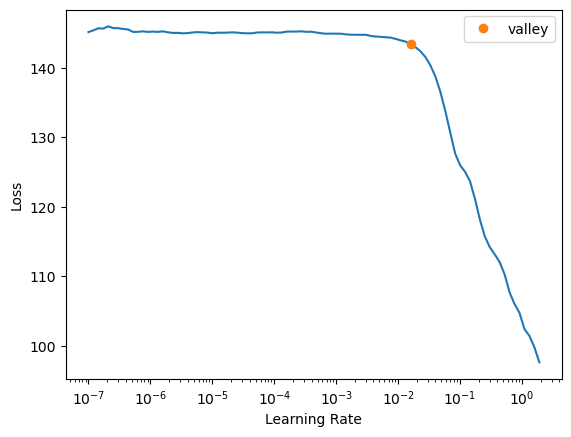

In [15]:
model_nn.lr_find()

In [16]:
model_nn.fit_one_cycle(30, 0.02)

epoch,train_loss,valid_loss,_rmse,time
0,143.100204,142.267487,11.927594,00:00
1,134.222839,111.816139,10.574316,00:00
2,93.420731,14.481365,3.805439,00:00
3,43.660297,0.207120,0.455105,00:00
4,20.605371,0.236838,0.486660,00:00
5,9.884183,0.210848,0.459182,00:00
6,4.781115,0.080072,0.282970,00:00
7,2.325555,0.029362,0.171354,00:00
8,1.139868,0.038136,0.195286,00:00
9,0.572378,0.090853,0.301419,00:00


In [17]:
nn_preds, nn_targs = model_nn.get_preds()
r_mse(nn_preds, nn_targs)

0.118819

### Ensemble models

In [18]:
train_xs = trn_dls.train.xs
train_y = trn_dls.train.y
valid_xs = trn_dls.valid.xs
valid_y = trn_dls.valid.y

In [19]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

### xgboost

In [20]:
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 5,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'n_estimators': 3000,
    'early_stopping_rounds': 100
}
model_xgb = XGBRegressor(**xgb_params)
model_xgb.fit(
            train_xs, train_y,
            eval_set=[(valid_xs, valid_y)],
            verbose=100
        )

[0]	validation_0-rmse:0.39333
[100]	validation_0-rmse:0.20463
[200]	validation_0-rmse:0.14555
[300]	validation_0-rmse:0.12910
[400]	validation_0-rmse:0.12421
[500]	validation_0-rmse:0.12262
[600]	validation_0-rmse:0.12218
[700]	validation_0-rmse:0.12203
[800]	validation_0-rmse:0.12187
[900]	validation_0-rmse:0.12178
[1000]	validation_0-rmse:0.12169
[1100]	validation_0-rmse:0.12166
[1200]	validation_0-rmse:0.12162
[1300]	validation_0-rmse:0.12155
[1400]	validation_0-rmse:0.12152
[1500]	validation_0-rmse:0.12151
[1600]	validation_0-rmse:0.12146
[1700]	validation_0-rmse:0.12144
[1800]	validation_0-rmse:0.12142
[1900]	validation_0-rmse:0.12141
[2000]	validation_0-rmse:0.12140
[2100]	validation_0-rmse:0.12140
[2200]	validation_0-rmse:0.12138
[2300]	validation_0-rmse:0.12132
[2400]	validation_0-rmse:0.12133
[2406]	validation_0-rmse:0.12133


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=3000,
             n_jobs=None, num_parallel_tree=None, ...)

In [21]:
m_rmse(model_xgb, train_xs,train_y), m_rmse(model_xgb, valid_xs, valid_y)

(0.087773, 0.121323)

In [22]:
cat_params = {
    'objective': 'RMSE',
    'iterations': 3000,
    'learning_rate': 0.01,
    'depth': 6,
    'l2_leaf_reg': 3,
    'random_strength': 0.1,
    'min_data_in_leaf': 5,
    'bagging_temperature': 1,
    'early_stopping_rounds': 100
}
model_cat = CatBoostRegressor(**cat_params)
model_cat.fit(
            train_xs, train_y,
            eval_set=[(valid_xs, valid_y)],
            verbose=False
        )

In [23]:
m_rmse(model_cat, train_xs,train_y), m_rmse(model_cat, valid_xs, valid_y)

(0.063522, 0.115959)

# Testset predictions

In [ ]:
test_df = pd.read_csv(path/'test.csv', low_memory=False)
tdf = add_features(test_df, is_train=False)

numeric_cols = tdf.select_dtypes(include=['float64', 'int64']).columns
tdf = handle_outliers(tdf, numeric_cols)

In [ ]:
test_dls = TabularPandas(tdf, 
                         procs=[FillMissing, Categorify, Normalize],
                        cat_names=cat_names,
                         cont_names=cont_names,
                         y_names=None,
                         splits=None).dataloaders(bs=32)

test_xs = test_dls.train.xs

In [ ]:
p_xgb = model_xgb.predict(test_xs)
p_cat = model_cat.predict(test_xs)

In [35]:
tdl = model_nn.dls.test_dl(tdf)
p,_ = model_nn.get_preds(dl=tdl)
p_nn = to_np(p.squeeze())

In [36]:
preds_log = (0.3*p_xgb + 0.3*p_cat + 0.4*p_nn)
preds_final = np.expm1(preds_log)
preds_final

array([123982.31574475, 168361.0795035 , 168696.87776403, ...,
       144477.21692157, 126590.81201903, 196616.33844972])

### Kaggle Submission

In [ ]:
preds_df = pd.DataFrame(preds_final, columns=['SalePrice'])

preds_df['Id'] = test_df['Id']

submission = preds_df[['Id', 'SalePrice']]
submission.head(3)

### Kaggle results

kaggle score 0.12740 排名#873 : 0.5xgb+0.5cat

In [53]:
submission.to_csv('houseprice_env.csv', index=False) 

kaggle score  0.14752 : 0.4xgb+0.3cat+0.3nn

In [109]:
submission.to_csv('houseprice_nn_env.csv', index=False) 

kaggle score 0.12735 排名#865 : 0.7xgb+0.3cat (so far best⭐️)

In [131]:
submission.to_csv('houseprice_env2.csv', index=False) 

kaggle score: 0.15234. No improvement

In [40]:
submission.to_csv('houseprice_nn_env2.csv', index=False) 

In [52]:
from fastkaggle import *

push_notebook('apple9855wang', 'House-Price-Predictions-practice-2',
             title='House-Price-Predictions-practice-2',
             file='0062_kaggle_houseprice.ipynb',
             competition='house-prices-advanced-regression-techniques'
             )

Kernel version 1 successfully pushed.  Please check progress at https://www.kaggle.com/code/apple9855wang/house-price-predictions-practice-2
